LSTM
==

In [2]:
from random import shuffle

import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
filename= '../data/french_clean.txt'

In [4]:
def reverse_sequence(nouns):
    return [noun[::-1] for noun in nouns]

def pad_sequence(sequence,pad_size,pad_token):
    # returns a list of the characters in the sequence with additional pad tokens to match pad_size if needed
    return list(sequence) + [pad_token] * (pad_size - len(sequence))

def code_sequence(charseq,encodingmap,unk_token='<unk>'):
    # charseq is a sequence of chars
    return [encodingmap[char] if char in encodingmap 
            else encodingmap[unk_token] for char in charseq]

def decode_sequence(idxseq,decodingmap):
    # idxseq is a list of integers
    return [decodingmap[idx] for idx in idxseq]

In [5]:
def read_data(filename, reverse_nouns=False):
    with open(filename, 'r', encoding='utf-8') as file:
        data = [line.strip() for line in file.readlines()]

    X, y = [], []
    for pair in data:
        noun, gender = pair.split(', ')
        if reverse_nouns:
            noun = reverse_sequence(noun)
        X.append(noun)
        y.append(gender)
    
    return X, y

In [6]:
def vocabulary(filename, labels=False, pad_token='<pad>', unk_token='<unk>'):
    
    nouns, genders = read_data(filename, reverse_nouns=False)
    
    if labels:
        sym2idx = {sym: idx for idx, sym in enumerate(set(genders))}
    else:
        noun_chars = set(char for noun in nouns for char in noun) # split the nouns into characters
        sym2idx = {sym: idx for idx, sym in enumerate(noun_chars)}
        sym2idx[unk_token] = len(sym2idx)
        sym2idx[pad_token] = len(sym2idx)

    idx2sym = {idx: sym for sym, idx in sym2idx.items()}

    return idx2sym, sym2idx

In [7]:
# Author: Benoit Crabbé (with slight modifications)
class DataGenerator:

      def __init__(self, filename, reverse_nouns=False, pad_token='<pad>', unk_token='<unk>'):

          self.pad_token = pad_token
          self.unk_token = unk_token

          self.input_idx2sym,self.input_sym2idx   = vocabulary(filename,False)
          self.output_idx2sym,self.output_sym2idx = vocabulary(filename,True)

          nouns, genders = read_data(filename, reverse_nouns=reverse_nouns)
          self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(nouns, genders, test_size=0.2)

      def generate_batches(self,batch_size,validation=False):

          if validation:
              X = self.X_test
              y = self.y_test
          else:
              X = self.X_train
              y = self.y_train

          assert(len(X) == len(y))

          N     = len(X)
          idxes = list(range(N))

          # Data ordering
          shuffle(idxes)
          idxes.sort(key=lambda idx: len(X[idx]))

          # batch generation
          bstart = 0
          while bstart < N:
              bend        = min(bstart+batch_size,N)
              batch_idxes = idxes[bstart:bend]
              batch_len   = max(len(X[idx]) for idx in batch_idxes)
              Xpad        = [pad_sequence(X[idx],batch_len,self.pad_token) for idx in batch_idxes]
              seqX        = [code_sequence(x,self.input_sym2idx,self.unk_token) for x in Xpad]
              seqY        = [self.output_sym2idx[y[idx]] for idx in batch_idxes]

              assert(len(seqX) == len(seqY))
              yield (seqX,seqY)
              bstart += batch_size

Model
==

Train the model by feeding it words in reverse order (since we want to start from the end of the word) and the corresponding genders. The model will learn to predict the gender based on the characters seen so far.

Takes preprocessed words as input:
- tokenized into characters 
- each character mapped to a unique integer id (same with each gender)
- sequences should be padded so they all have the same length

In [16]:
class GenderLSTM(nn.Module):

    def __init__(self, datagenerator, embedding_dim, hidden_dim, device='cpu'):
        super(GenderLSTM, self).__init__()
        self.to(device)

        invocab_size = len(datagenerator.input_idx2sym)
        outvocab_size = len(datagenerator.output_idx2sym)

        self.device = torch.device(device)
        self.pad_idx = datagenerator.input_sym2idx[datagenerator.pad_token]
        self.embedding = nn.Embedding(invocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, outvocab_size)
        self.log_softmax = nn.LogSoftmax(dim=-1)

        for param in self.parameters():
            param.requires_grad = True


    def forward(self, inputs):
        embeds = self.embedding(inputs)
        lstm_out, _ = self.lstm(embeds)
        logits = self.fc(lstm_out)   # shape: (batch_size, sequence_length, num_classes) 
        # add softmax to get probability distributions
        log_probabilities = self.log_softmax(logits)   # probability distribution over the classes for each character in the sequence
        # it would also be a good idea to calibrate the model (dividing c by a value T (tempreture) that is a hyperparameter that can be tuned --> ask Timothee)
        return log_probabilities  


    def train_model(self, datagenerator, n_epochs, batch_size, learning_rate=0.001):
        criterion = nn.NLLLoss(ignore_index=self.pad_idx)
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        self.train_all_char_accuracies = [] # will contain the average accuracies of all character positions after each epoch (a list of lists)
        self.valid_all_char_accuracies = []
        
        self.train_max_indecies = []    # will contain the index of the character with the highest average accuracy after each epoch
        self.valid_max_indecies = []

        self.train_max_accuracies = []  # will contain the accuracy of the character with the highest average accuracy after each epoch
        self.valid_max_accuracies = []
        
        self.avg_valid_losses = []
        
        for epoch in range(n_epochs):
            print(f'Epoch: {epoch}')
            epoch_train_accuracies = [] # will contain lists, each of length sequence_length, containing average accuracies for each character position in a batch of words. At the end, the lists will need to be padded to have the same length, converted to a matrix, and the average of each column computed as the overall average accuracy for each character position. The highest accuracy in the resulting list will show which character position is overall most predictive of gender.
            epoch_valid_accuracies = []
            epoch_train_losses = []
            epoch_valid_losses = []
            
            self.train()
            for inputs, labels in datagenerator.generate_batches(batch_size):
                X = torch.LongTensor(inputs).to(self.device)
                Y = torch.LongTensor(labels).to(self.device) # shape: (batch_size)

                optimizer.zero_grad()
                Y_log_probs = self.forward(X)    # shape: (batch_size, sequence_length, num_classes)

                batch_train_accuracies = []    # list to store the accurracies at each character position for all words in the batch. The index of each inner list will be the index of the character (the character position)
                batch_train_losses = []   # Ditto for the losses

                # loop over each character position of all the words in the batch
                for char_position in range(Y_log_probs.size(1)):                              # Y_log_probs.size(1) = sequence_length
                    Y_char_position_log_probs = Y_log_probs[:, char_position, :]              # Shape: (batch_size, num_classes)
                    Y_char_position_pred = torch.argmax(Y_char_position_log_probs, dim=-1)    # Shape: (batch_size) --> contains predictions for all words in the batch, having seen all the characters up to and including the current position (or just the character at the current position?)
                    
                    # compute accuracy for the current position
                    correct = (Y_char_position_pred == Y)
                    char_position_accuracy = float(torch.sum(correct)) / len(correct) # model accuracy over the full batch => having seen char_position many characters (or the character at the current position - I'm not sure which) what proportion of the words in the batch had their gender correctly predicted
                    batch_train_accuracies.append(char_position_accuracy)

                    # compute the loss for the current position
                    char_position_loss = criterion(Y_char_position_log_probs, Y)
                    batch_train_losses.append(char_position_loss.item())
                                    
                epoch_train_accuracies.append(batch_train_accuracies)

                # NOTE: currently, I'm using the average of the losses of all characters in the sequence as the loss for that sequence; but for the accuracy, I'm using that of the character which had the highest accuracy. 
                avg_loss = torch.tensor(batch_train_losses, requires_grad=True).mean()
                avg_loss.backward()

                # Check gradients
                # for param in self.parameters():
                #     print(param.grad)

                optimizer.step()
                epoch_train_losses.append(avg_loss.item())

            # pad the batch accuracy lists with 0s so they have the same lengths, and convert into a 2D pytorch tensor (matrix)
            max_length = max(len(l) for l in epoch_train_accuracies)
            padded_epoch_train_accuracies = torch.tensor([l + [0.0] * (max_length - len(l)) for l in epoch_train_accuracies])   # shape: (num_of_batches, max_sequence_length)
            
            # compute the average of each column as the overall average accuracy for each character position
            # dividing the sum of non-zero elements for each column by the total number of non-zero elements for that column
            mask = padded_epoch_train_accuracies != 0.0 # we don't want the padding to affect the average accuracy values
            avg_char_position_accuracies = (padded_epoch_train_accuracies * mask).sum(dim=0) / mask.sum(dim=0)   # shape: (max_sequence_length)
            self.train_all_char_accuracies.append(avg_char_position_accuracies)
            
            # The index with the highest accuracy is indicative of the overall most predictive position
            max_accuracy, max_index = avg_char_position_accuracies.max(dim=0)
            self.train_max_indecies.append(max_index)
            self.train_max_accuracies.append(max_accuracy)

            self.eval()
            for val_inputs, val_labels in datagenerator.generate_batches(batch_size, validation=True):
                with torch.no_grad():
                    X_val = torch.LongTensor(val_inputs).to(self.device)
                    Y_val = torch.LongTensor(val_labels).to(self.device)

                    Y_val_log_probs = self.forward(X_val)
                    
                    batch_valid_accuracies = []
                    batch_valid_losses = []

                    # loop over each character position of all the words in the batch
                    for char_position in range(Y_val_log_probs.size(1)):                              
                        Y_char_position_log_probs = Y_val_log_probs[:, char_position, :]          # Shape: (batch_size, num_classes)
                        Y_char_position_pred = torch.argmax(Y_char_position_log_probs, dim=-1)    # Shape: (batch_size) --> contains predictions for all words in the batch, having seen all the characters up to and including the current position (or just the character at the current position?)
                        
                        # compute accuracy for the current position
                        correct = (Y_char_position_pred == Y_val)
                        char_position_accuracy = float(torch.sum(correct)) / len(correct) # model accuracy over the full batch => having seen char_position many characters (or the character at the current position - I'm not sure which) what proportion of the words in the batch had their gender correctly predicted
                        batch_valid_accuracies.append(char_position_accuracy)

                        # compute the loss for the current position
                        char_position_loss = criterion(Y_char_position_log_probs, Y_val)
                        batch_valid_losses.append(char_position_loss.item())
                                        
                    epoch_valid_accuracies.append(batch_valid_accuracies)

                    # NOTE: currently, I'm using the average of the losses of all characters in the sequence as the loss for that sequence; but for the accuracy, I'm using that of the character which had the highest accuracy. 
                    avg_loss = torch.mean(torch.tensor(batch_valid_losses, requires_grad=False))
                    epoch_valid_losses.append(avg_loss.item())

            # pad the batch accuracy lists with 0s so they have the same lengths, and convert into a 2D pytorch tensor (matrix)
            max_length = max(len(l) for l in epoch_valid_accuracies)
            padded_epoch_valid_accuracies = torch.tensor([l + [0.0] * (max_length - len(l)) for l in epoch_valid_accuracies])   # shape: (num_of_batches, max_sequence_length)
                    
            # compute the average of each column as the overall average accuracy for each character position
            mask = padded_epoch_valid_accuracies != 0.0
            avg_char_position_accuracies = (padded_epoch_valid_accuracies * mask).sum(dim=0) / mask.sum(dim=0)    # shape: (max_sequence_length)
            self.valid_all_char_accuracies.append(avg_char_position_accuracies)
                    
            # The index with the highest accuracy is indicative of the overall most predictive position
            max_accuracy, max_index = avg_char_position_accuracies.max(dim=0)
            self.valid_max_indecies.append(max_index)
            self.valid_max_accuracies.append(max_accuracy)


            # store & report metrics at the end of each epoch
            avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
            avg_valid_loss = sum(epoch_valid_losses) / len(epoch_valid_losses)
            self.avg_valid_losses.append(avg_valid_loss)

            print(f'[Train] Loss: {avg_train_loss * 100:.2f}%   Max Accuracy: {self.train_max_accuracies[-1] * 100:.2f}%   Index: {self.train_max_indecies[-1]}')      
            print(f'[Valid] Loss: {avg_valid_loss * 100:.2f}%   Max Accuracy: {self.valid_max_accuracies[-1] * 100:.2f}%   Index: {self.valid_max_indecies[-1]}')
            print('-' * 100)


    def predict(self, datagenerator, batch_size):
        # TODO
        ...


In [17]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_dim = 64
hidden_dim = 128
n_epochs = 10
batch_size = 32

data_generator = DataGenerator(filename, reverse_nouns=True)
model = GenderLSTM(data_generator, embedding_dim, hidden_dim, device=DEVICE)
model.train_model(data_generator, n_epochs, batch_size)

Epoch: 0
[Train] Loss: 68.83%   Max Accuracy: 56.44%   Index: 1
[Valid] Loss: 68.74%   Max Accuracy: 57.23%   Index: 1
----------------------------------------------------------------------------------------------------
Epoch: 1
[Train] Loss: 68.83%   Max Accuracy: 57.14%   Index: 21
[Valid] Loss: 68.74%   Max Accuracy: 57.23%   Index: 1
----------------------------------------------------------------------------------------------------
Epoch: 2
[Train] Loss: 68.83%   Max Accuracy: 56.44%   Index: 1
[Valid] Loss: 68.74%   Max Accuracy: 57.23%   Index: 1
----------------------------------------------------------------------------------------------------
Epoch: 3
[Train] Loss: 68.83%   Max Accuracy: 56.44%   Index: 1
[Valid] Loss: 68.74%   Max Accuracy: 57.23%   Index: 1
----------------------------------------------------------------------------------------------------
Epoch: 4
[Train] Loss: 68.83%   Max Accuracy: 56.44%   Index: 1
[Valid] Loss: 68.74%   Max Accuracy: 57.23%   Index: 1


In [10]:
# toy example
x = torch.tensor([[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0], [1.0, 2.0, 3.0, 4.0, 5.0, 0.0, 0.0], [1.0, 2.0, 3.0, 4.0, 0.0, 0.0, 0.0]])

mask = x != 0.0

# dividing the sum of non-zero elements for each column by the total number of non-zero elements for each column
mean = (x * mask).sum(dim=0) / mask.sum(dim=0)

print((x * mask).sum(dim=0))
print(mask.sum(dim=0))
print(mean)

tensor([ 3.,  6.,  9., 12., 10.,  6.,  7.])
tensor([3, 3, 3, 3, 2, 1, 1])
tensor([1., 2., 3., 4., 5., 6., 7.])


In [93]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot2(train_acc, valid_acc, valid_losses, train_max_indices, dev_max_indices):

    gs = gridspec.GridSpec(5, 1, height_ratios=[1, 1, 0.1, 1, 1]) 

    fig = plt.figure(figsize=(10, 12))
    plt.subplots_adjust(hspace=0.4)

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    # The third row is used to add space
    ax4 = plt.subplot(gs[3])
    ax5 = plt.subplot(gs[4])

    n_epochs = range(1, len(valid_losses) + 1)    # number of epochs

    # Plotting Accuracy and Loss
    ax1.set_title('Average Loss & Max Accuracy Evolution Over Epochs')
    ax1.plot(n_epochs, train_acc, marker='o', color='steelblue', label='Max Training Accuracy')
    ax1.plot(n_epochs, valid_acc, marker='o', color='orange', label='Max Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, linestyle='--')

    ax2.plot(n_epochs, valid_losses, marker='o', color='firebrick', label='Average Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, linestyle='--')

    # Plotting max indices
    ax4.set_title('Character position (index) with the highest average accuracy at each epoch')
    ax4.bar(n_epochs, train_max_indices, color='steelblue', label='Training Set')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Indices')
    ax4.legend()
    ax4.grid(True, linestyle='--')

    ax5.bar(n_epochs, dev_max_indices, color='orange', label='Validation Set')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('Indices')
    ax5.legend()
    ax5.grid(True, linestyle='--')

    plt.show()

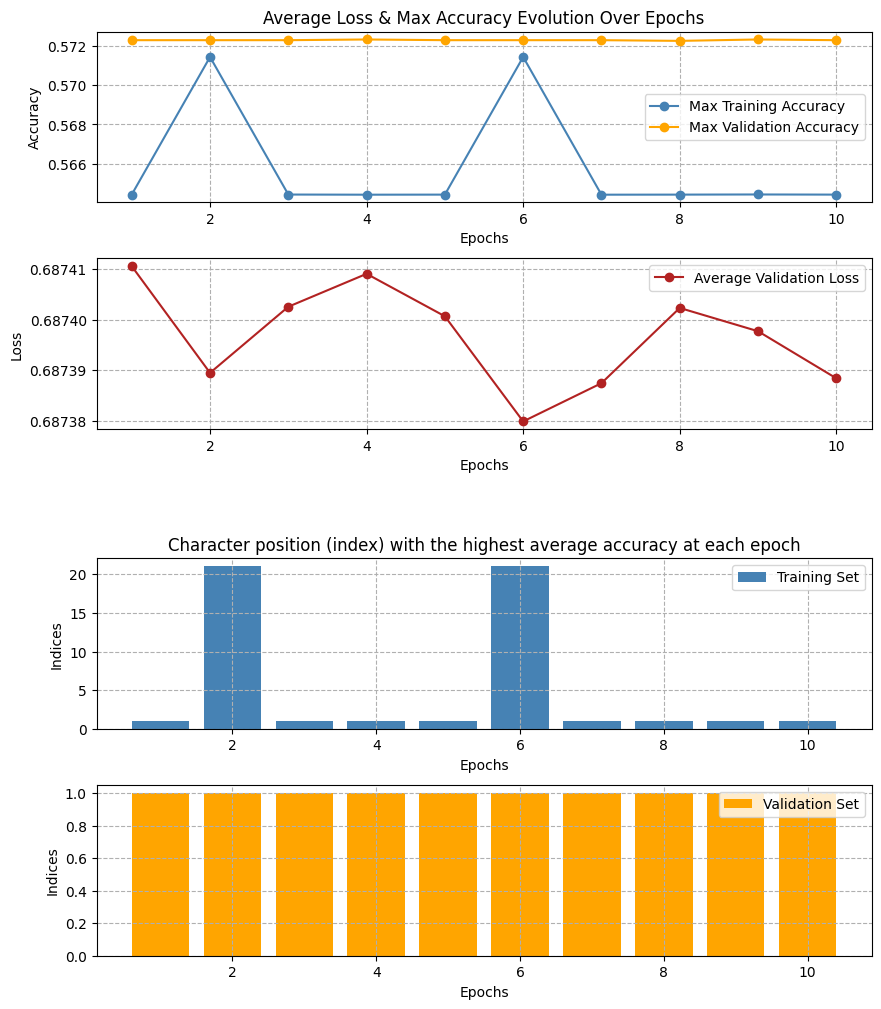

In [94]:
plot2(model.train_max_accuracies, model.valid_max_accuracies, model.avg_valid_losses, model.train_max_indecies, model.valid_max_indecies)

In [112]:
train_all_char_accuracies = [tensor.tolist() for tensor in model.train_all_char_accuracies]
train_char_accuracies = pd.DataFrame(train_all_char_accuracies).rename_axis('epochs')
train_char_accuracies

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
epochs,,,,,,,,,,,,,,,,,,,,,
0,0.558224,0.564432,0.562001,0.560195,0.555479,0.547908,0.535403,0.521762,0.500882,0.475130,...,0.437500,0.500000,0.500000,0.464286,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
1,0.558232,0.564440,0.561982,0.560360,0.555455,0.547921,0.535452,0.521890,0.500845,0.474950,...,0.473214,0.535714,0.571429,0.535714,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429
2,0.558224,0.564432,0.561974,0.560326,0.555451,0.547904,0.535505,0.522001,0.500838,0.474920,...,0.437500,0.500000,0.500000,0.464286,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
3,0.558217,0.564425,0.561993,0.560318,0.555555,0.547904,0.535539,0.521704,0.501031,0.474910,...,0.433036,0.428571,0.428571,0.392857,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571
4,0.558221,0.564428,0.561970,0.560326,0.555591,0.547904,0.535433,0.521675,0.500838,0.474779,...,0.453125,0.464286,0.500000,0.428571,0.464286,0.464286,0.464286,0.464286,0.464286,0.464286
5,0.558228,0.564436,0.562035,0.560279,0.555507,0.547913,0.535549,0.521809,0.500897,0.475020,...,0.470982,0.535714,0.571429,0.535714,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429
6,0.558217,0.564425,0.562020,0.560345,0.555587,0.547904,0.535505,0.521581,0.500838,0.475191,...,0.450893,0.464286,0.464286,0.392857,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571
7,0.558221,0.564428,0.562054,0.560241,0.555587,0.547904,0.535505,0.521628,0.500942,0.475130,...,0.468750,0.500000,0.500000,0.428571,0.464286,0.464286,0.464286,0.464286,0.464286,0.464286
8,0.558228,0.564436,0.561959,0.560302,0.555515,0.547917,0.535520,0.521844,0.500942,0.475150,...,0.439732,0.500000,0.535714,0.500000,0.535714,0.535714,0.535714,0.535714,0.535714,0.535714


In [110]:
valid_all_char_accuracies = [tensor.tolist() for tensor in model.valid_all_char_accuracies]
valid_char_accuracies = pd.DataFrame(valid_all_char_accuracies).rename_axis('epochs')
valid_char_accuracies

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
epochs,,,,,,,,,,,,,,,,,,,,,
0,0.562606,0.572283,0.571227,0.565782,0.563686,0.559387,0.543470,0.524592,0.501311,0.486910,...,0.458333,0.416667,0.458333,0.458333,0.458333,0.458333,0.458333,0.458333,0.458333,0.458333
1,0.562606,0.572283,0.571192,0.565782,0.563686,0.559148,0.542929,0.524753,0.500483,0.485527,...,0.458333,0.416667,0.458333,0.458333,0.458333,0.458333,0.458333,0.458333,0.458333,0.458333
2,0.562606,0.572283,0.571227,0.566317,0.563686,0.559507,0.542929,0.524753,0.501104,0.486080,...,0.458333,0.416667,0.458333,0.458333,0.458333,0.458333,0.458333,0.458333,0.458333,0.458333
3,0.562641,0.572318,0.571263,0.565604,0.563612,0.559427,0.543245,0.524807,0.501380,0.486449,...,0.500000,0.458333,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
4,0.562570,0.572283,0.571227,0.566210,0.563686,0.558748,0.542929,0.524592,0.501311,0.486634,...,0.458333,0.416667,0.458333,0.458333,0.458333,0.458333,0.458333,0.458333,0.458333,0.458333
5,0.562606,0.572283,0.571192,0.565996,0.563686,0.559148,0.542794,0.523787,0.500483,0.485527,...,0.458333,0.416667,0.458333,0.458333,0.458333,0.458333,0.458333,0.458333,0.458333,0.458333
6,0.562606,0.572283,0.571227,0.565354,0.563575,0.559387,0.543065,0.524753,0.501311,0.485804,...,0.458333,0.416667,0.458333,0.458333,0.458333,0.458333,0.458333,0.458333,0.458333,0.458333
7,0.562570,0.572248,0.571192,0.565853,0.563760,0.559227,0.542749,0.524699,0.500828,0.485712,...,0.416667,0.375000,0.416667,0.416667,0.416667,0.416667,0.416667,0.416667,0.416667,0.416667
8,0.562606,0.572318,0.571227,0.565925,0.563723,0.559267,0.543110,0.524485,0.500966,0.485343,...,0.500000,0.458333,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
